In [1]:
import sys
sys.path.append("../") 

In [2]:
import pandas as pd
import numpy as np

In [3]:
from epimodel.preprocessing import preprocess_data
from epimodel.epiparam import EpidemiologicalParameters

In [4]:
data = preprocess_data("../data/synth_data_small.csv")

In [5]:
ep = EpidemiologicalParameters()

# construct random walk model

In [6]:
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from jax import random
import jax.numpy as jnp
import jax.scipy.signal as jss

import jax

import numpy as np
import matplotlib.pyplot as plt

In [6]:
def model(data, ep, ar_noise=0.025, ifr_noise=0.025, r_noise_scale=0.25):
    # data has nCMs, nRs, nDs as attributes
    
    alpha_i = numpyro.sample("alpha_i", dist.TruncatedNormal(low=-0.1, loc=np.zeros(data.nCMs), scale=0.2)) 
    cm_reduction = jnp.sum(data.active_cms * alpha_i.reshape((1, data.nCMs, 1)), axis=1)
    
    basic_R = numpyro.sample("R_base", dist.TruncatedNormal(low=0.1, loc=1.5*jnp.ones(data.nRs), scale=0.2))
#     basic_R = numpyro.sample("basic_R", dist.Uniform(low=0.1, high=2.5*jnp.ones(data.nRs)))
    log_Rt_noise = numpyro.sample("log_Rt_noise", dist.Normal(loc=np.zeros((data.nRs, data.nDs))))
    log_Rt = jnp.log(basic_R.reshape((data.nRs, 1))) - cm_reduction +  r_bo* jnp.cumsum(log_Rt_noise, axis=-1)
    
    Rt = numpyro.deterministic('Rt', jnp.exp(log_Rt)) # nRs x nDs
    
    seeding_padding = 7
    total_padding = ep.GIv.size-1
    
    seeding = numpyro.sample("seeding", dist.LogNormal(jnp.zeros((data.nRs, 1)), 5.))
    init_infections = jnp.zeros((data.nRs, total_padding))
    init_infections = jax.ops.index_add(init_infections, jax.ops.index[:, -seeding_padding:], jnp.repeat(seeding, seeding_padding, axis=-1))
    
    total_infections = jnp.zeros((data.nRs, seeding_padding + data.nDs))
    
    def discrete_renewal_transition(infections, R):
        # infections is an nR x total_padding size array of infections in the previous 
        # total_padding days. 
        new_infections = infections @ ep.GI_projmat
        new_infections = jax.ops.index_update(new_infections, jax.ops.index[:, -1], jnp.multiply(new_infections[:, -1], R))
        return new_infections, new_infections[:, -1]
    
    # we need to transpose R because jax.lax.scan scans over the first dimension. We want to scan over time
    # we also will transpose infections at the end 
    _, infections = jax.lax.scan(discrete_renewal_transition, init_infections, Rt.T)
    
    total_infections = jax.ops.index_update(total_infections, jax.ops.index[:, :seeding_padding], init_infections[:, -seeding_padding:])
    total_infections = jax.ops.index_update(total_infections, jax.ops.index[:, seeding_padding:], infections.T)
    
    total_infections = numpyro.deterministic('total_infections', total_infections)
    
    ar_rw = numpyro.sample("ar_rw", dist.Normal(np.zeros((data.nRs, data.nDs+seeding_padding)), ar_noise))
    # i.e., ar_0 is 1.
    ar_t = jnp.exp(jnp.cumsum(ar_rw, axis=-1))
    
    # lazy - probably can do better than uniform. 
    ifr_0 = numpyro.sample("ifr_0", dist.Uniform(low=0.01, high=np.ones((data.nRs, 1))))
    ifr_rw = numpyro.sample("ifr_rw", dist.Normal(np.zeros((data.nRs, data.nDs+seeding_padding)), ifr_noise)) 
    ifr_t = ifr_0 * jnp.exp(jnp.cumsum(ifr_rw, axis=-1))

    future_cases_t = jnp.multiply(total_infections, ar_t)
    future_deaths_t = jnp.multiply(total_infections, ifr_t)
        
#     # at the moment, this is technically neglecting the very earliest infections
    expected_cases = numpyro.deterministic('expected_cases', jss.convolve2d(future_cases_t, ep.DPCv, mode='full')[:, seeding_padding:data.nDs+seeding_padding])
    expected_deaths = numpyro.deterministic('expected_deaths', jss.convolve2d(future_deaths_t, ep.DPDv, mode='full')[:, seeding_padding:data.nDs+seeding_padding])
    psi_cases = numpyro.sample("psi_cases", dist.HalfNormal(5))
    psi_deaths = numpyro.sample("psi_deaths", dist.HalfNormal(5))
    
    with numpyro.handlers.mask(mask=np.logical_not(data.new_cases.mask)):
        observed_cases = numpyro.sample("observed_cases", dist.GammaPoisson(concentration=psi_cases, rate=psi_cases/expected_cases), obs=data.new_cases.data)
        
    with numpyro.handlers.mask(mask=np.logical_not(data.new_deaths.mask)):
        observed_deaths = numpyro.sample("observed_deaths", dist.GammaPoisson(concentration=psi_deaths, rate=psi_deaths/expected_deaths), obs=data.new_deaths.data)

In [8]:
from numpyro.infer import init_to_median

In [9]:
nuts_kernel = NUTS(model, init_strategy = init_to_median)

mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)

with numpyro.validation_enabled():
    res = mcmc.run(rng_key, data, ep)

posterior_samples = mcmc.get_samples(np.array([0]))

sample: 100%|██████████| 4000/4000 [09:32<00:00,  6.99it/s, 127 steps of size 2.93e-02. acc. prob=0.90] 


Note: this random walk model took an additional 5 minutes compared to the corrupted $R_t$ model

In [10]:
all_df = pd.read_csv('../data/synth_data_small.csv')
all_df['date'] = pd.to_datetime(all_df['date'])
all_df = all_df.set_index(['area', 'date'])

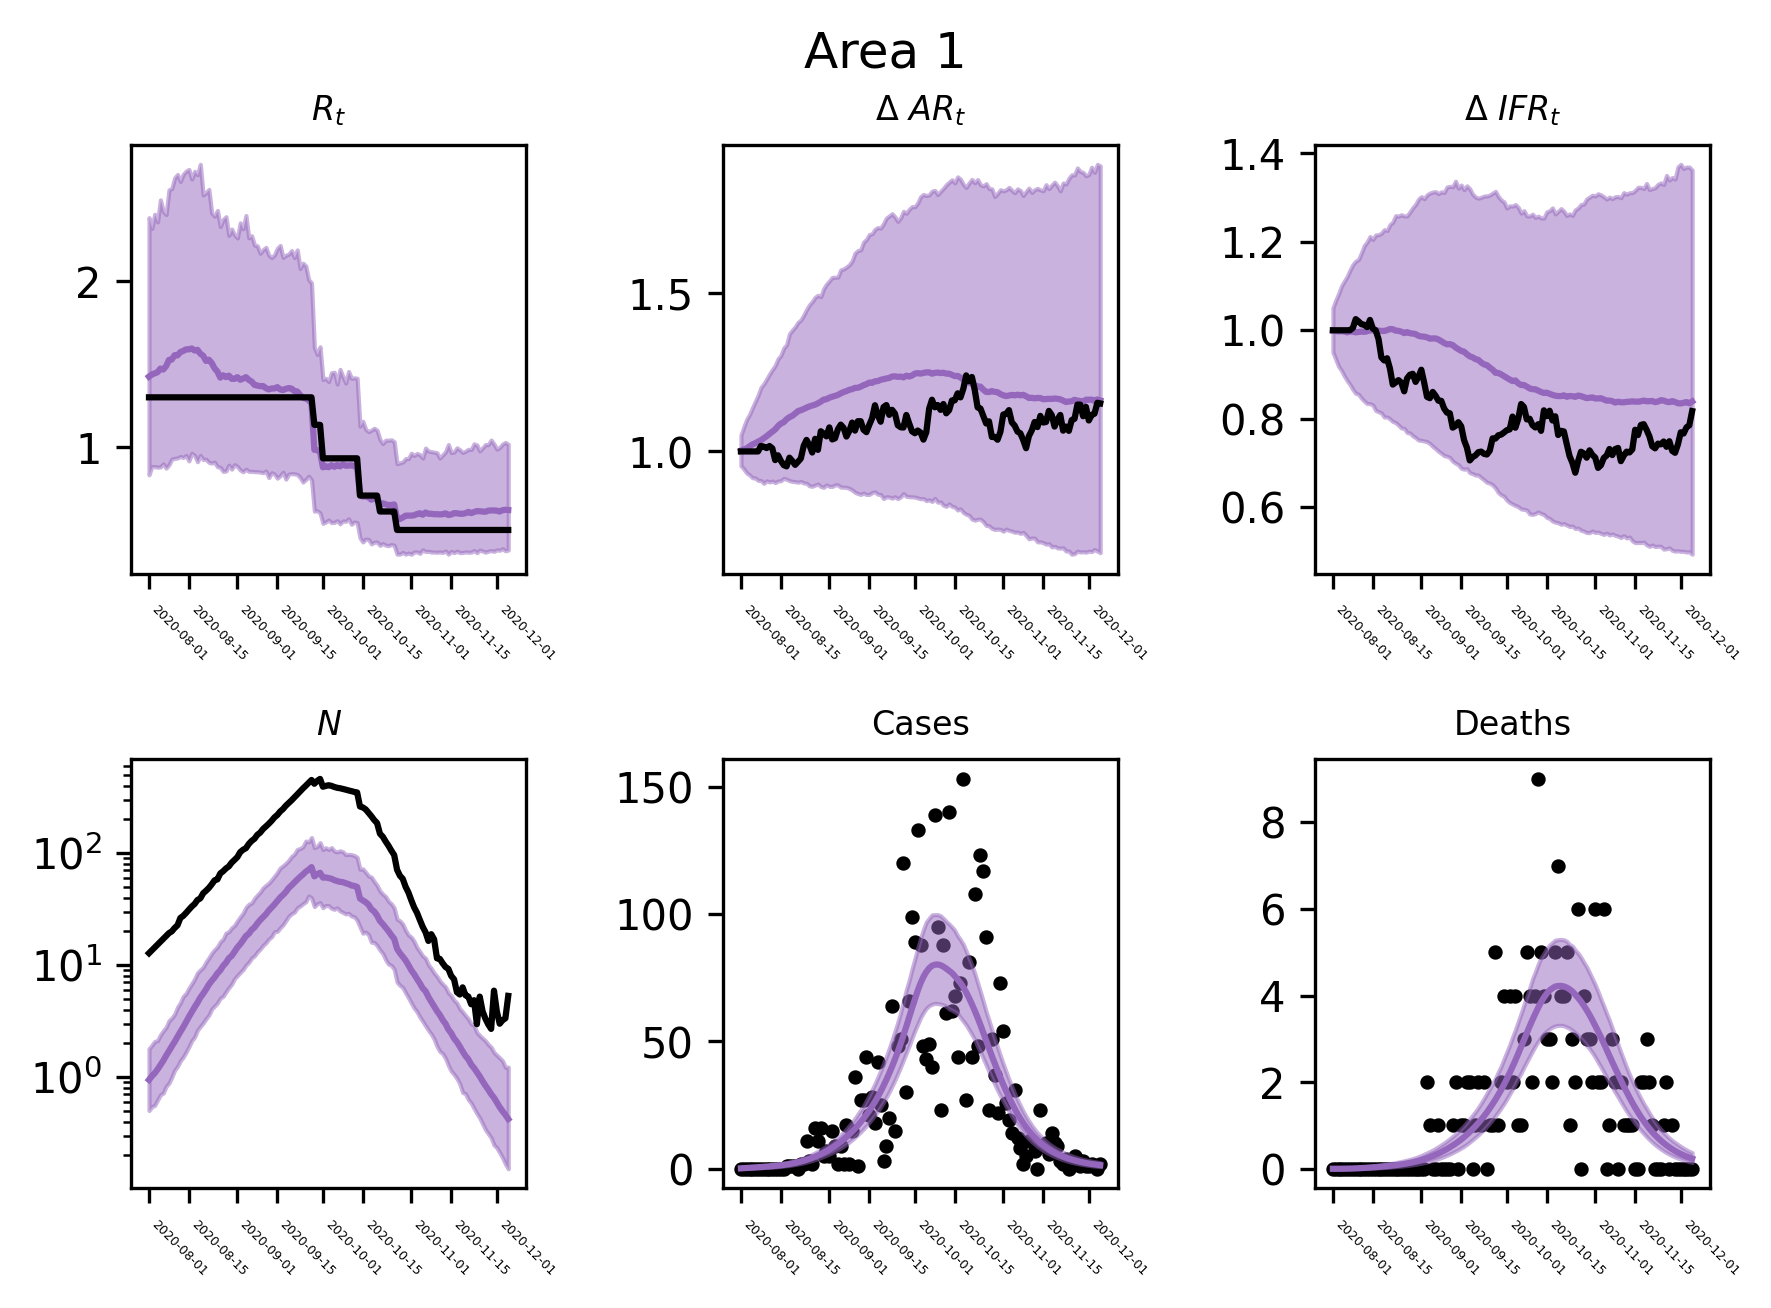

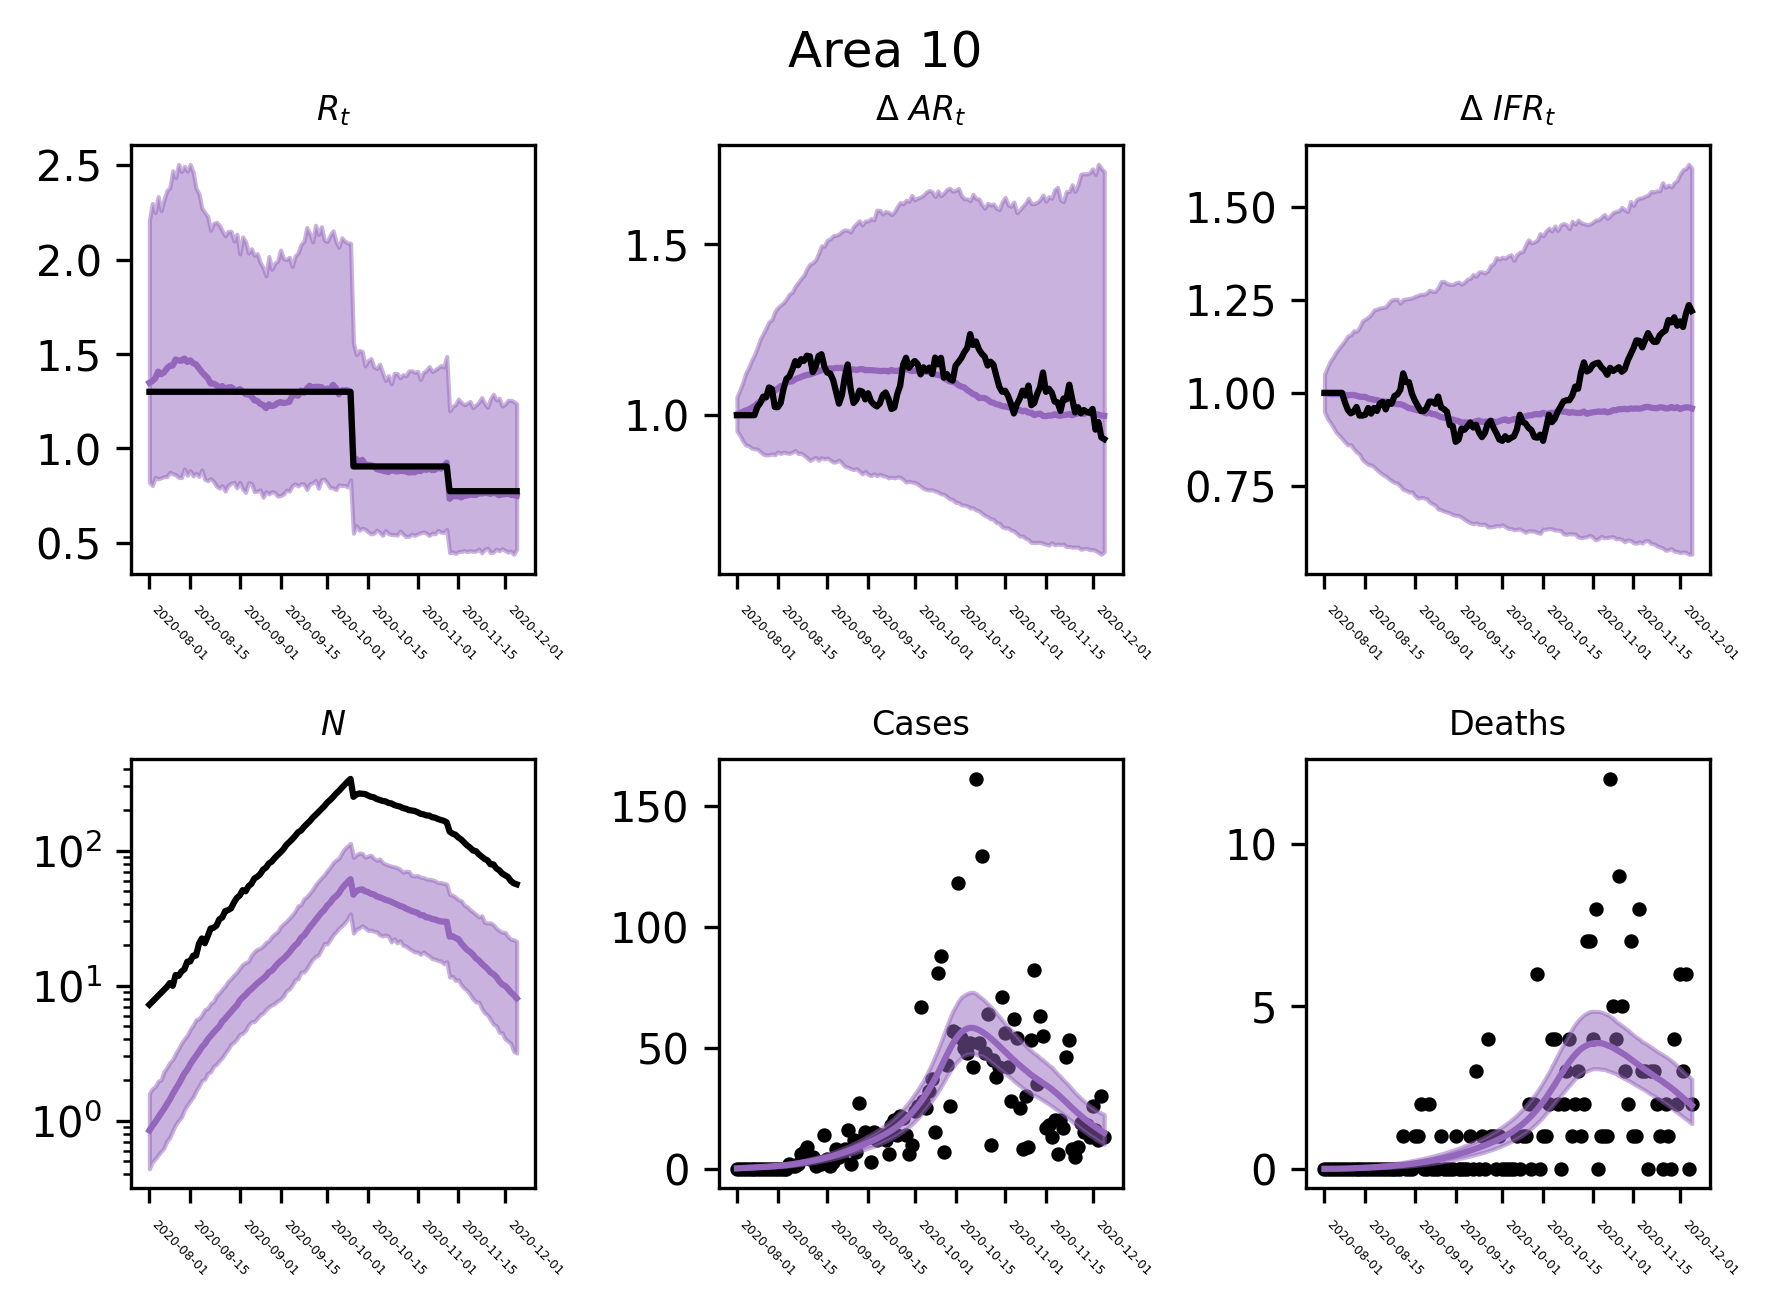

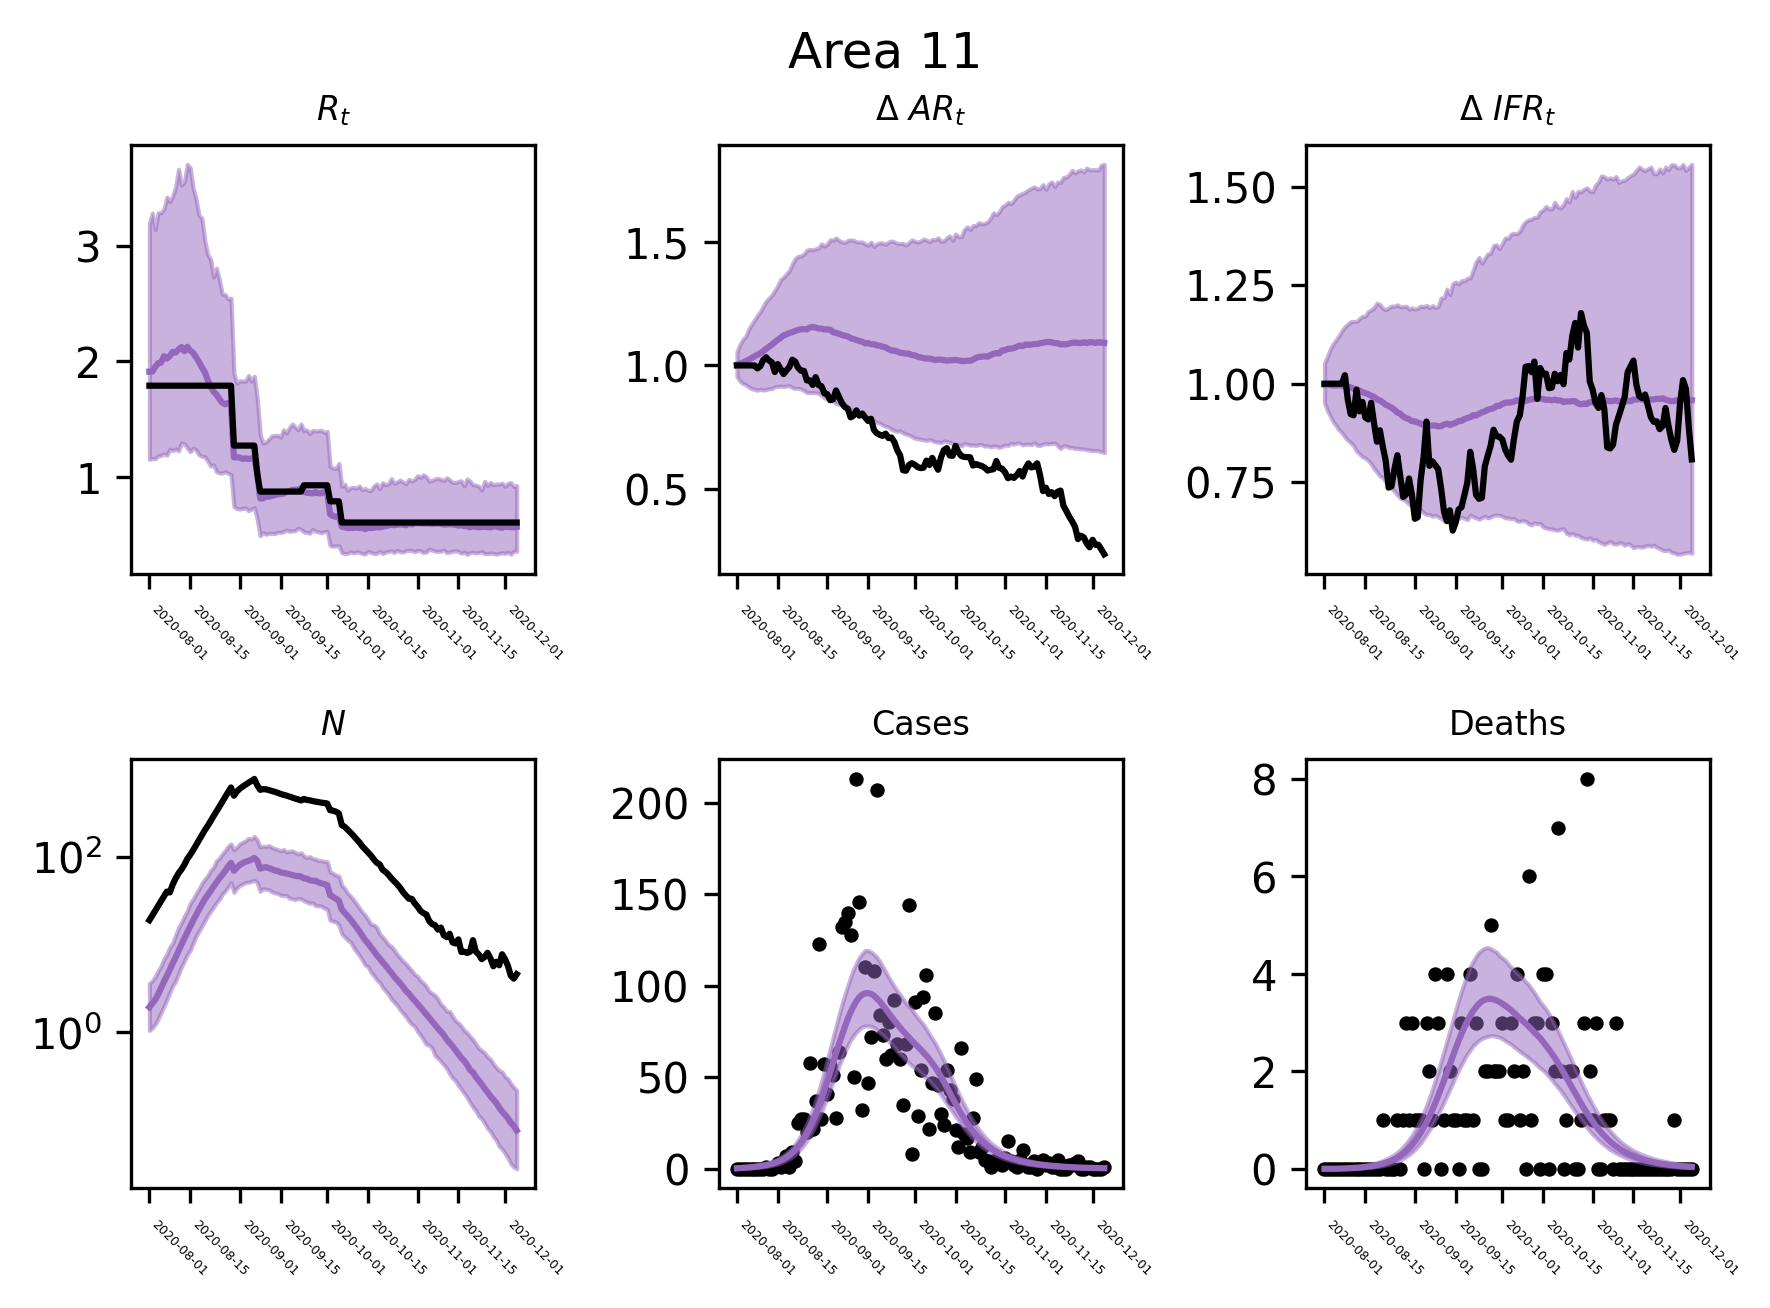

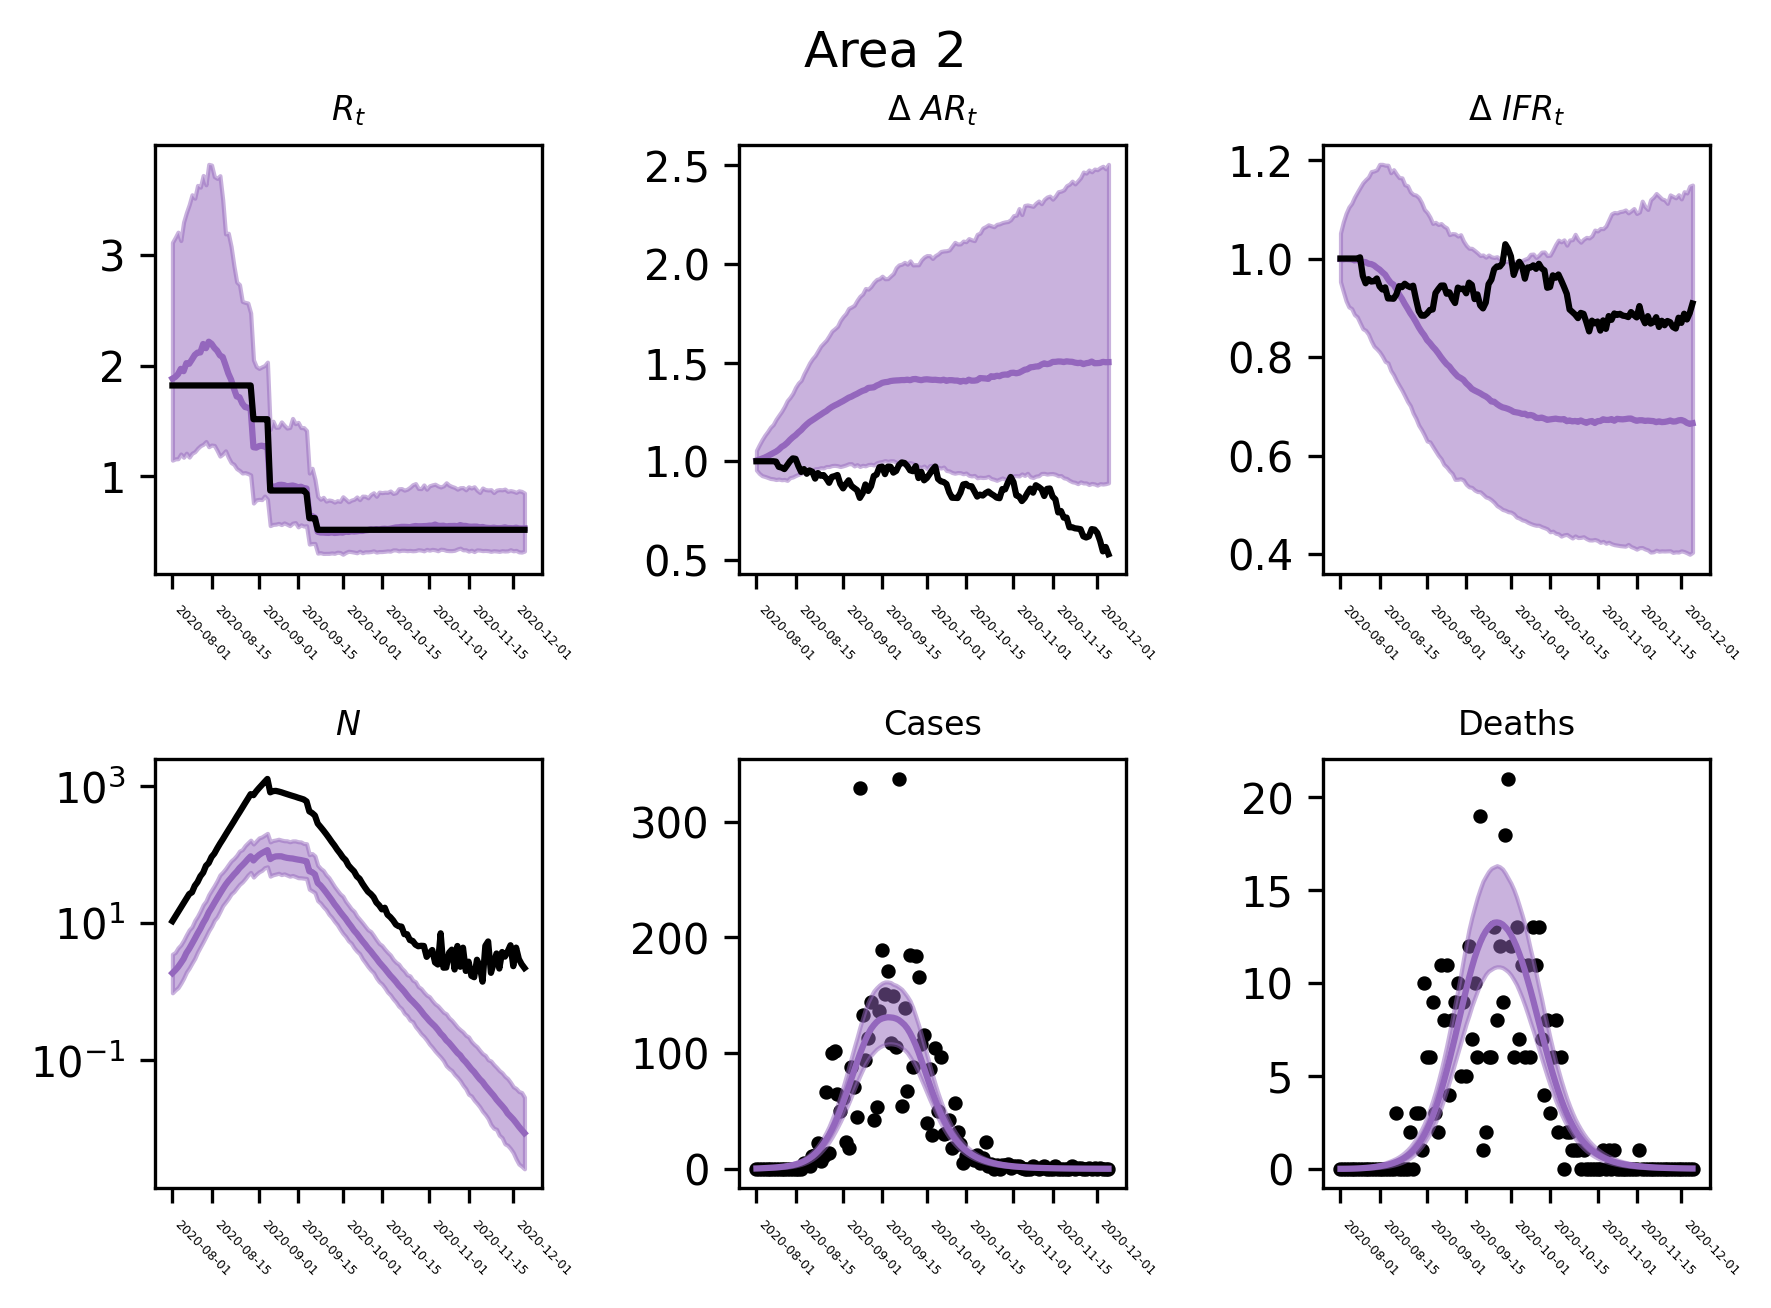

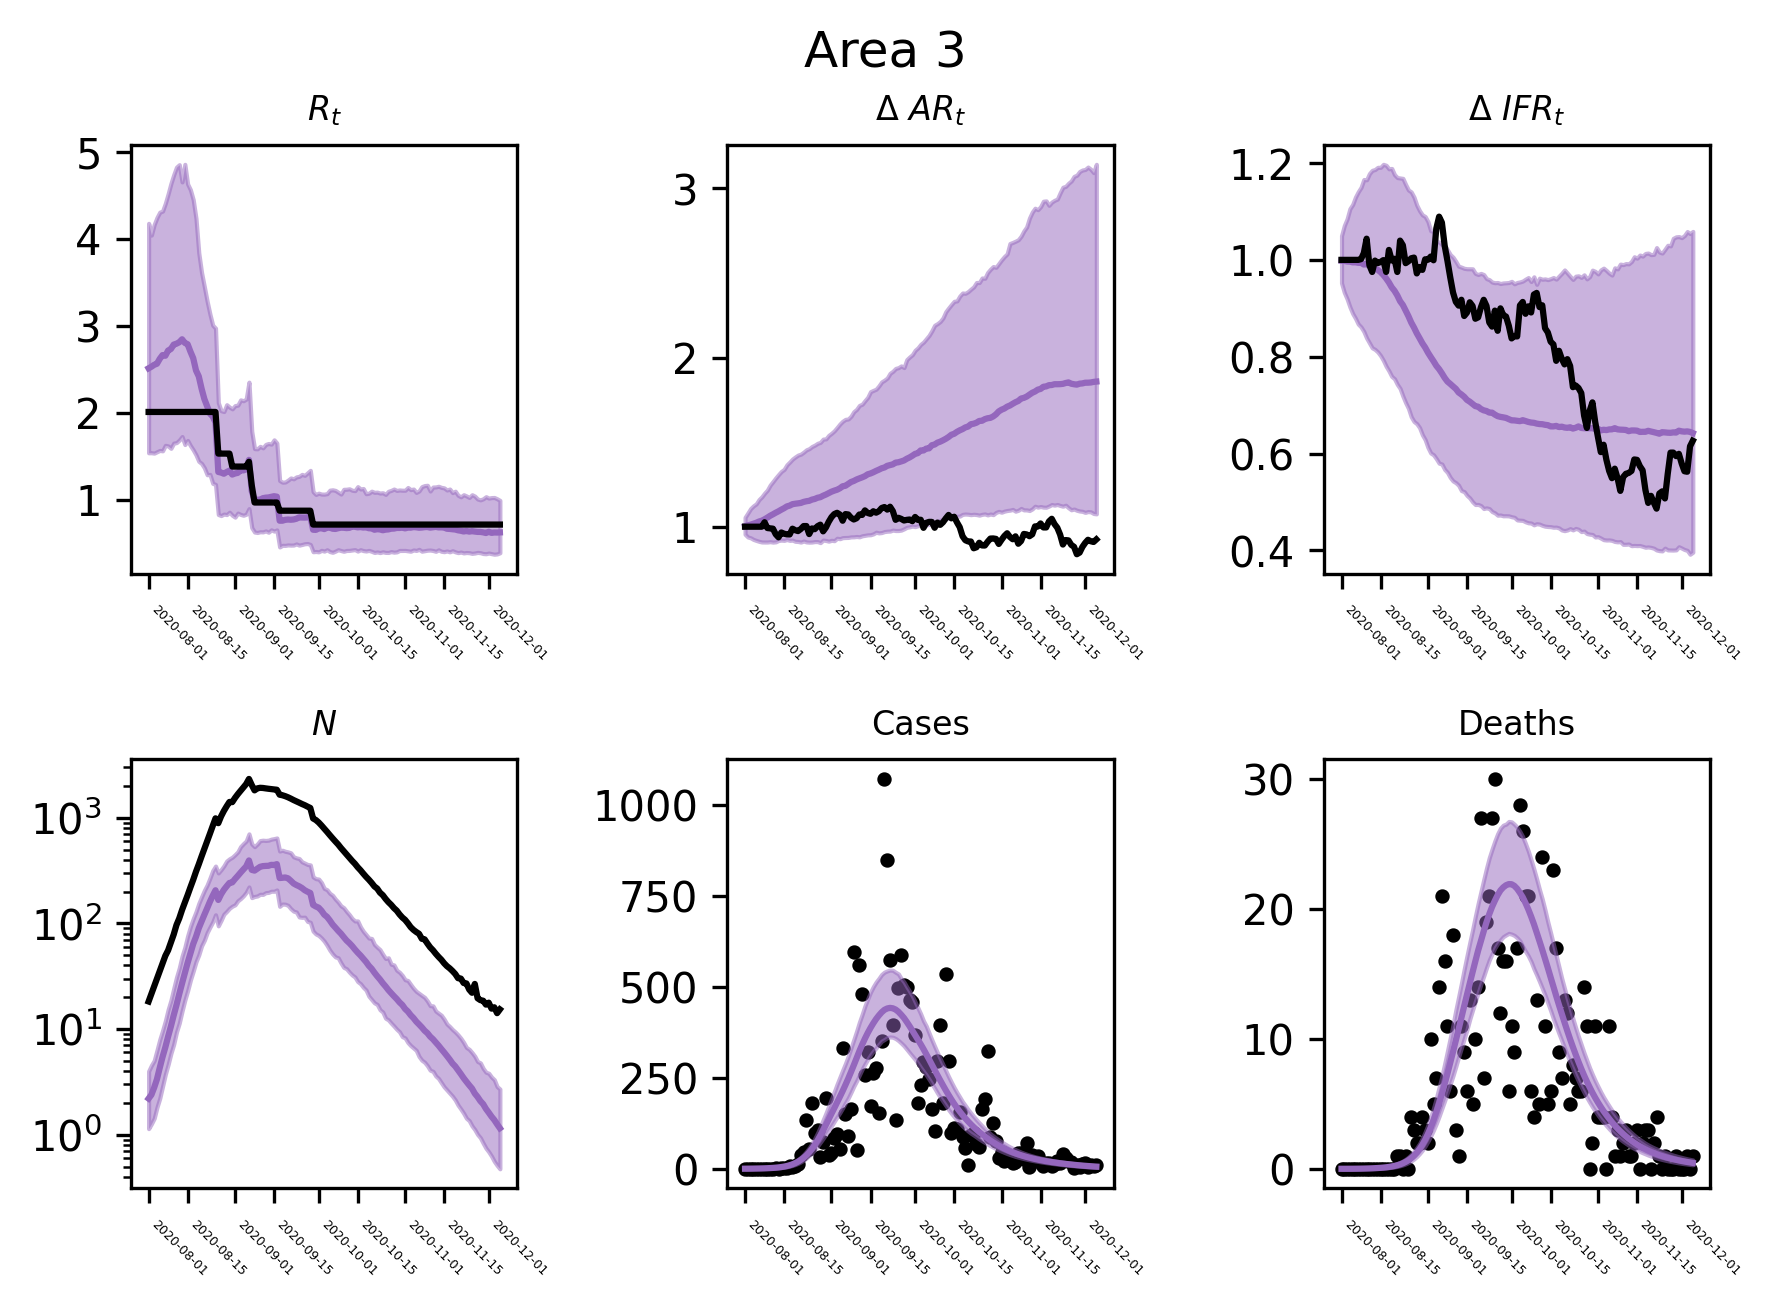

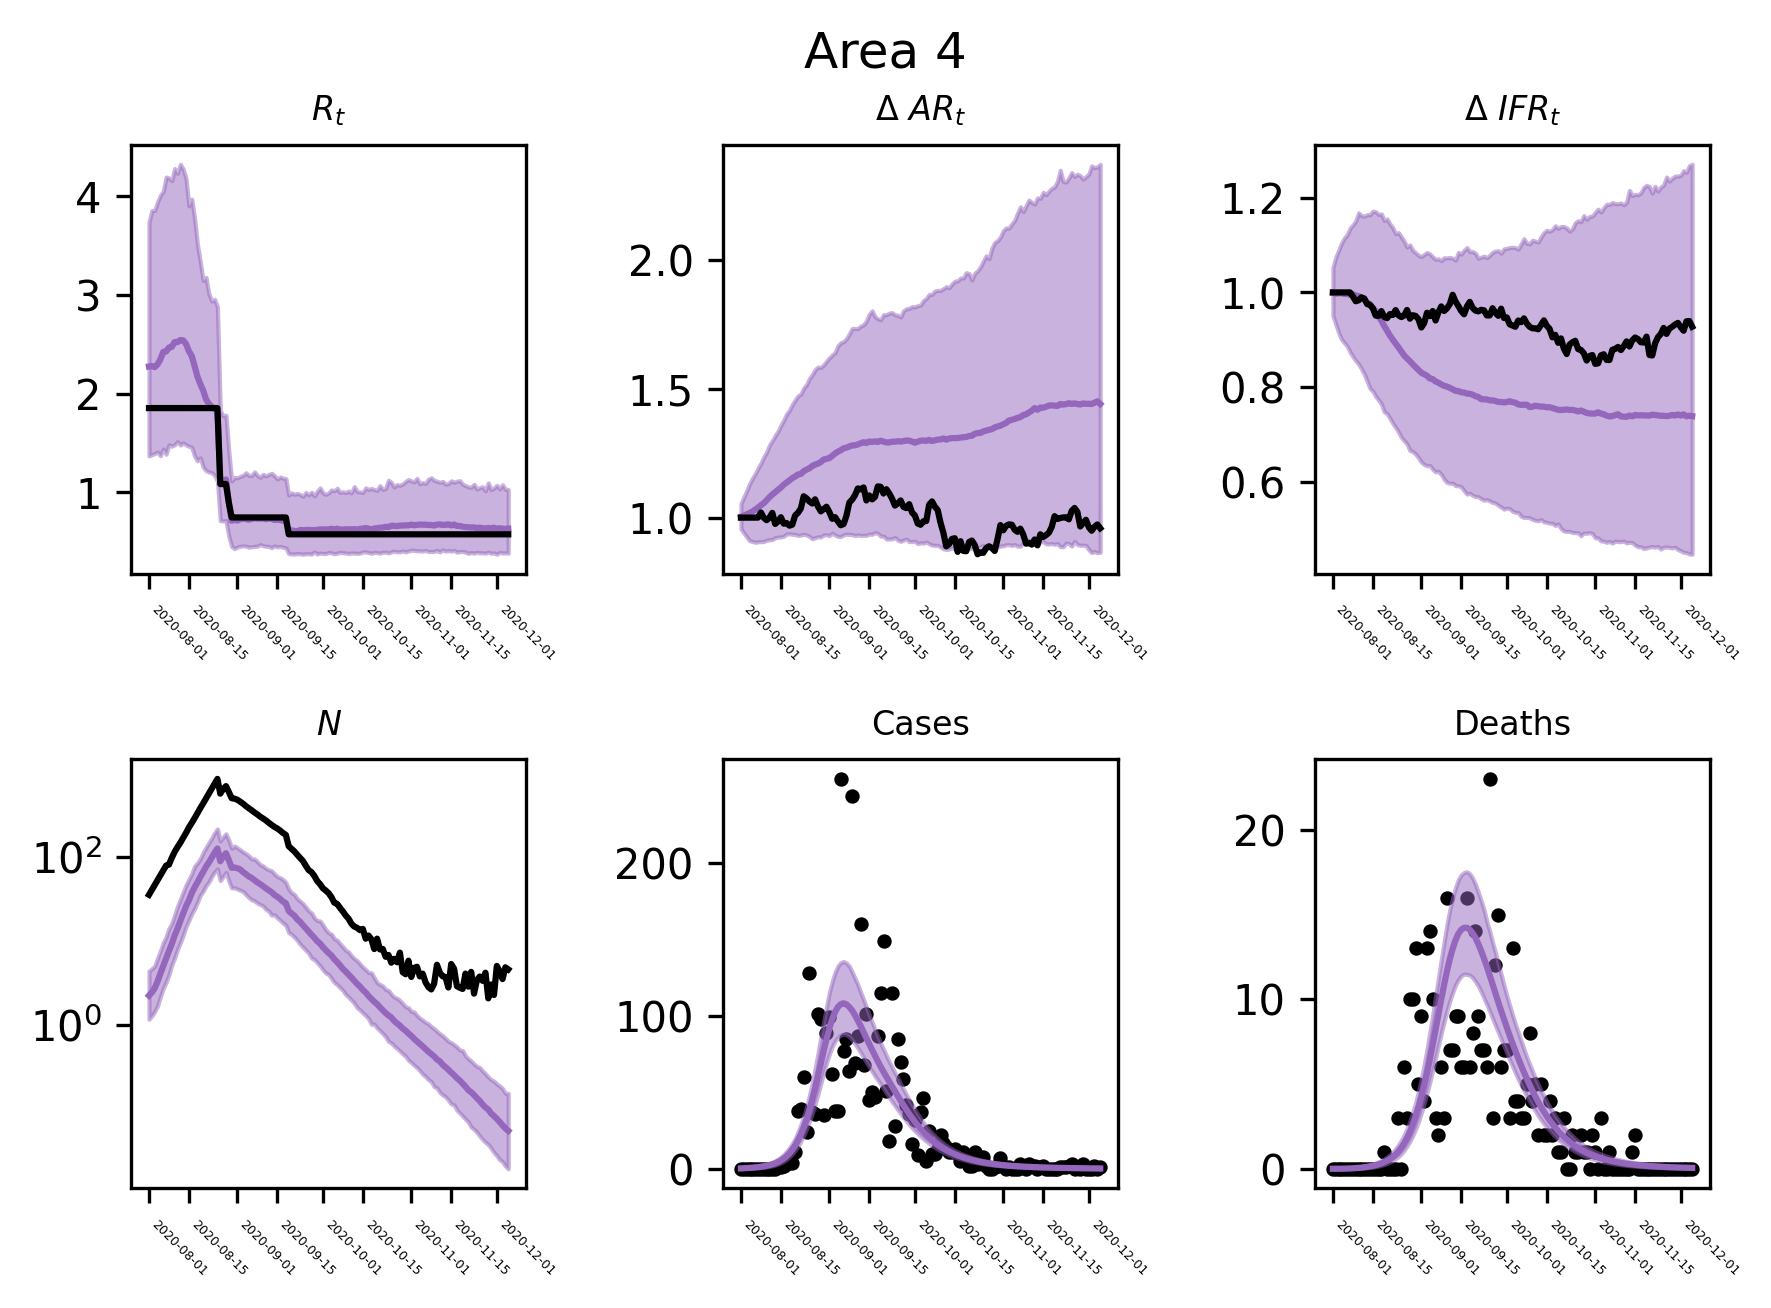

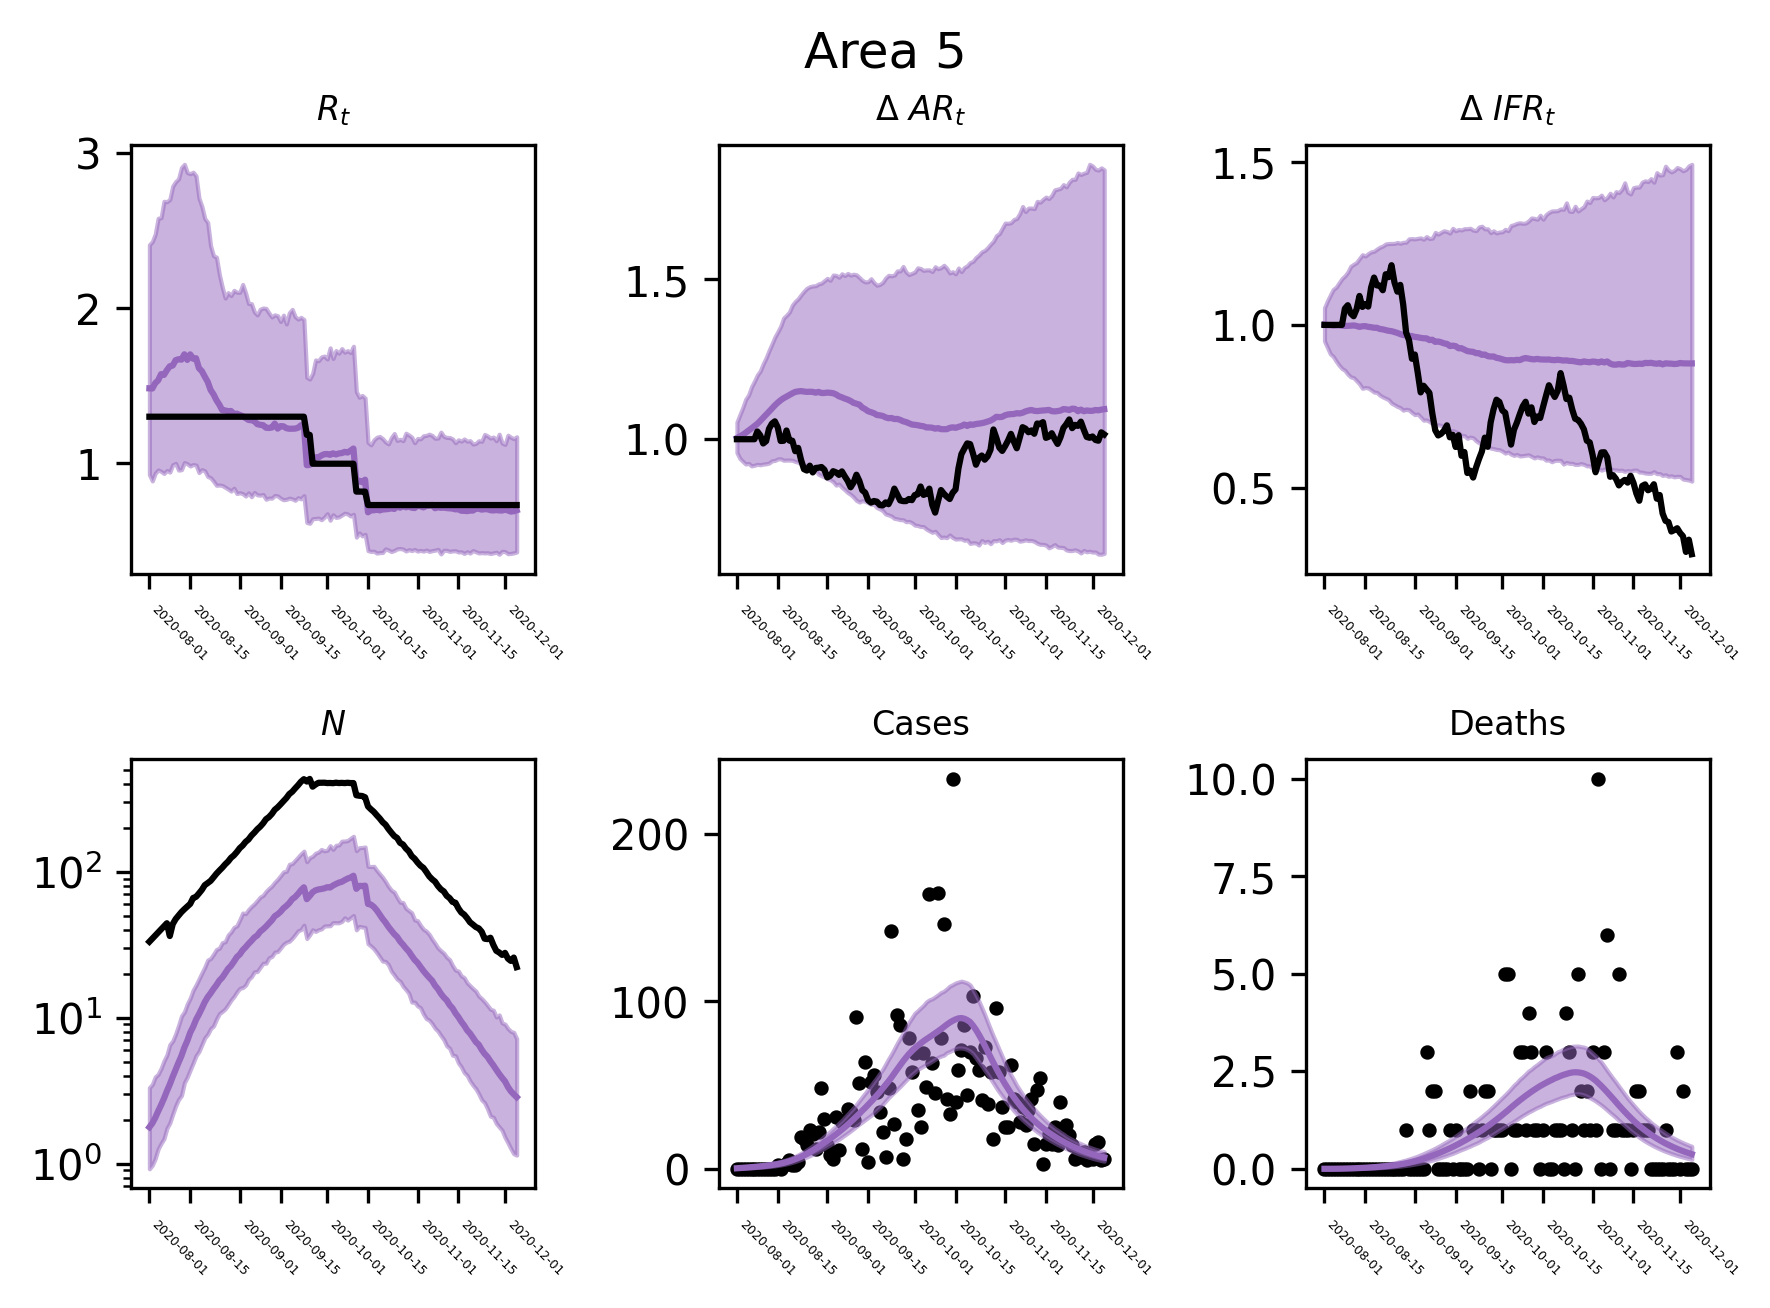

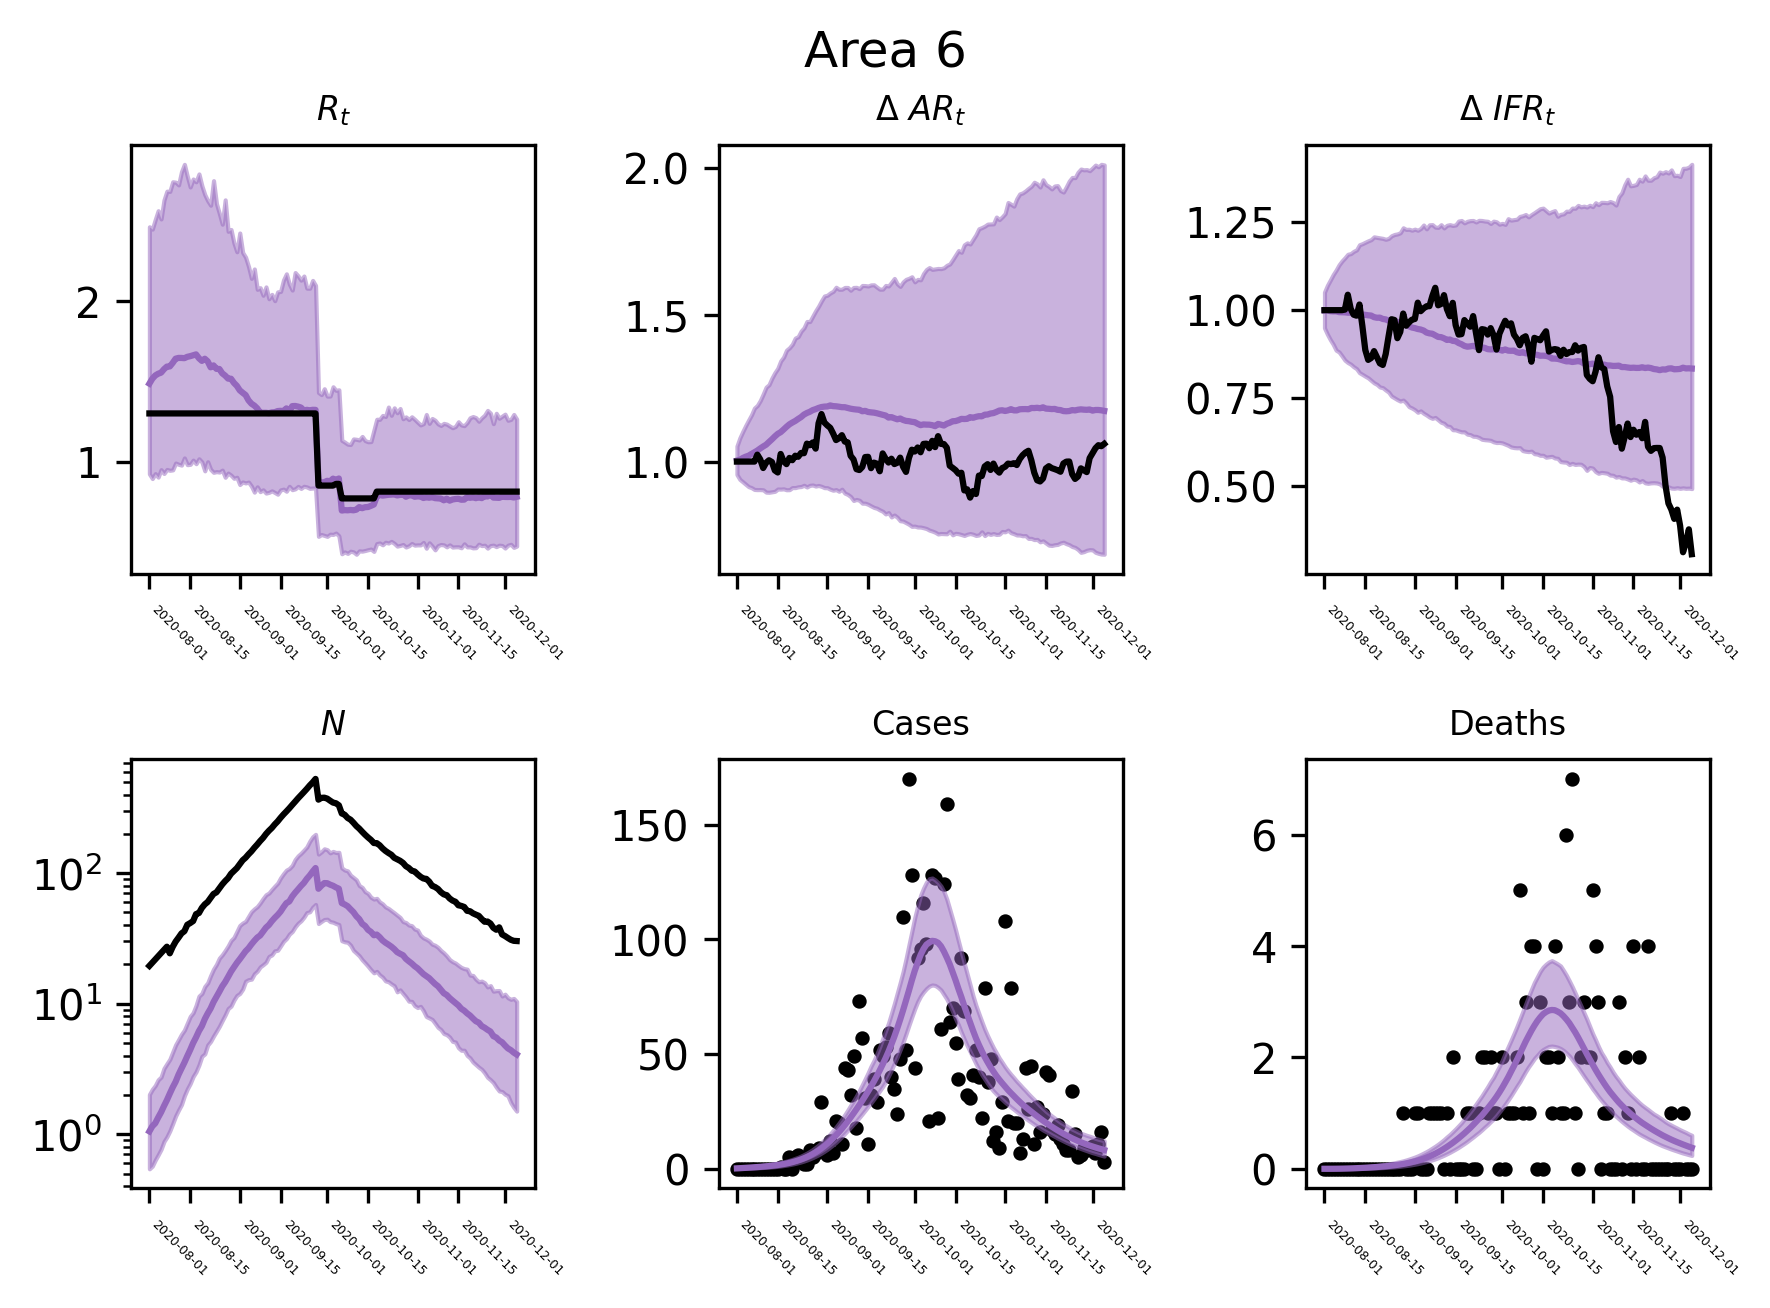

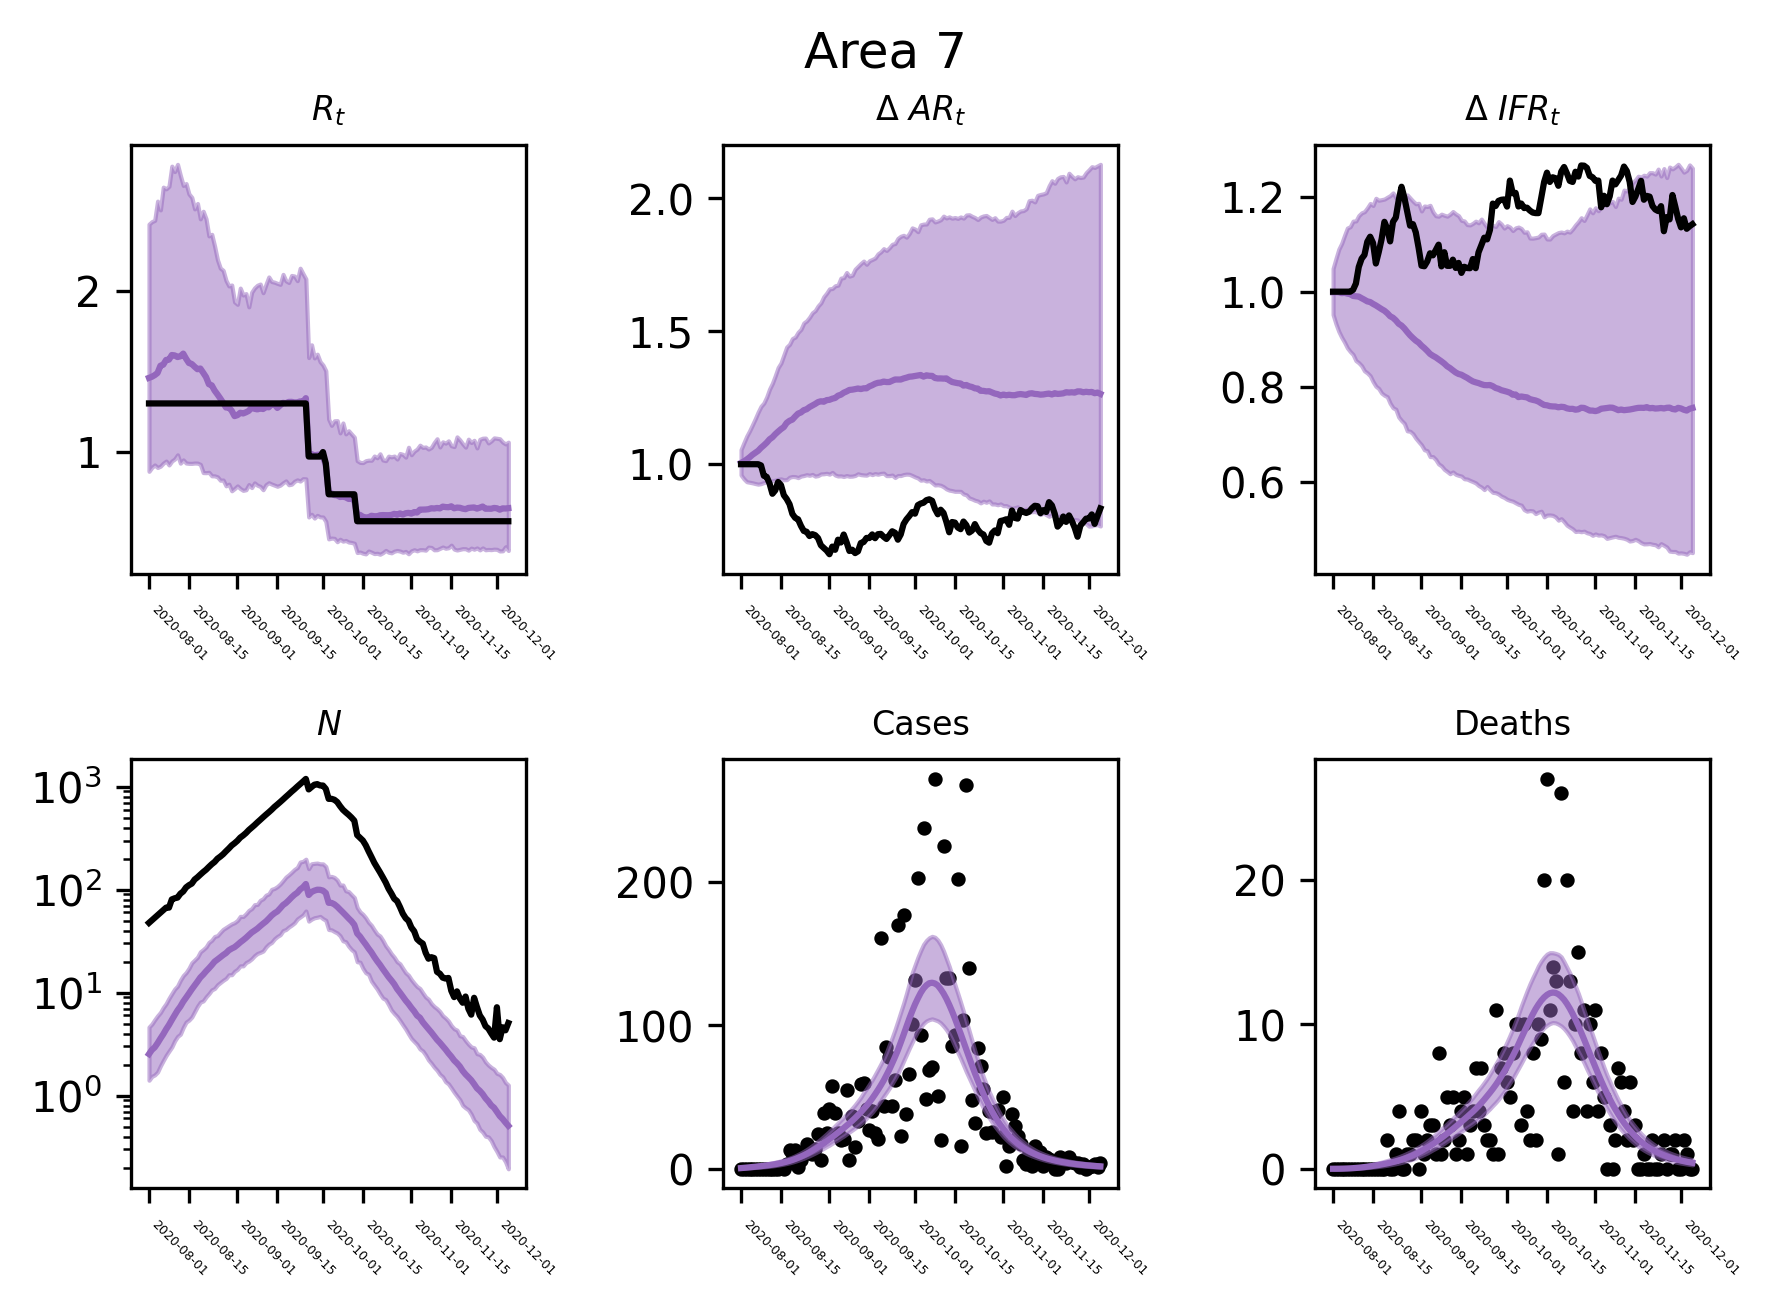

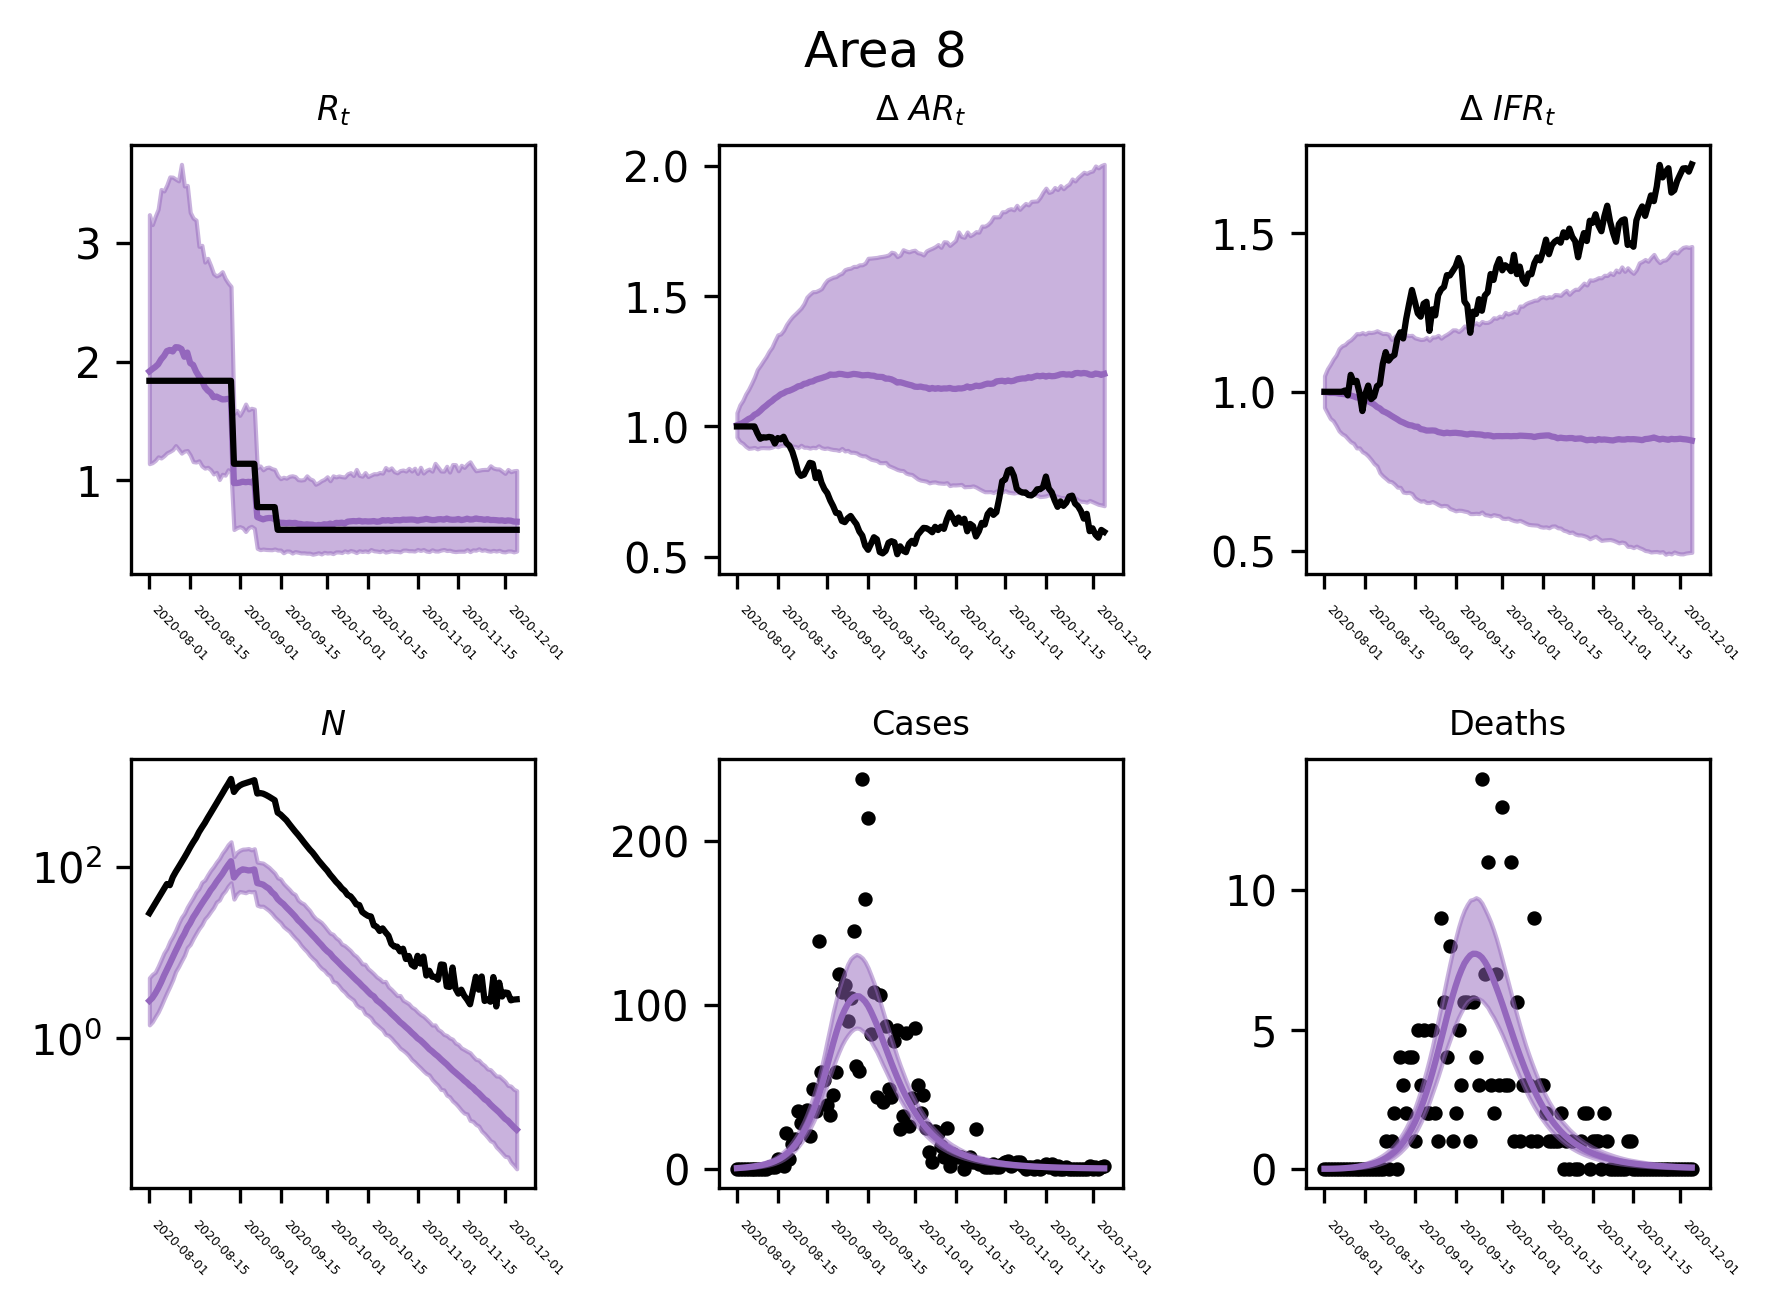

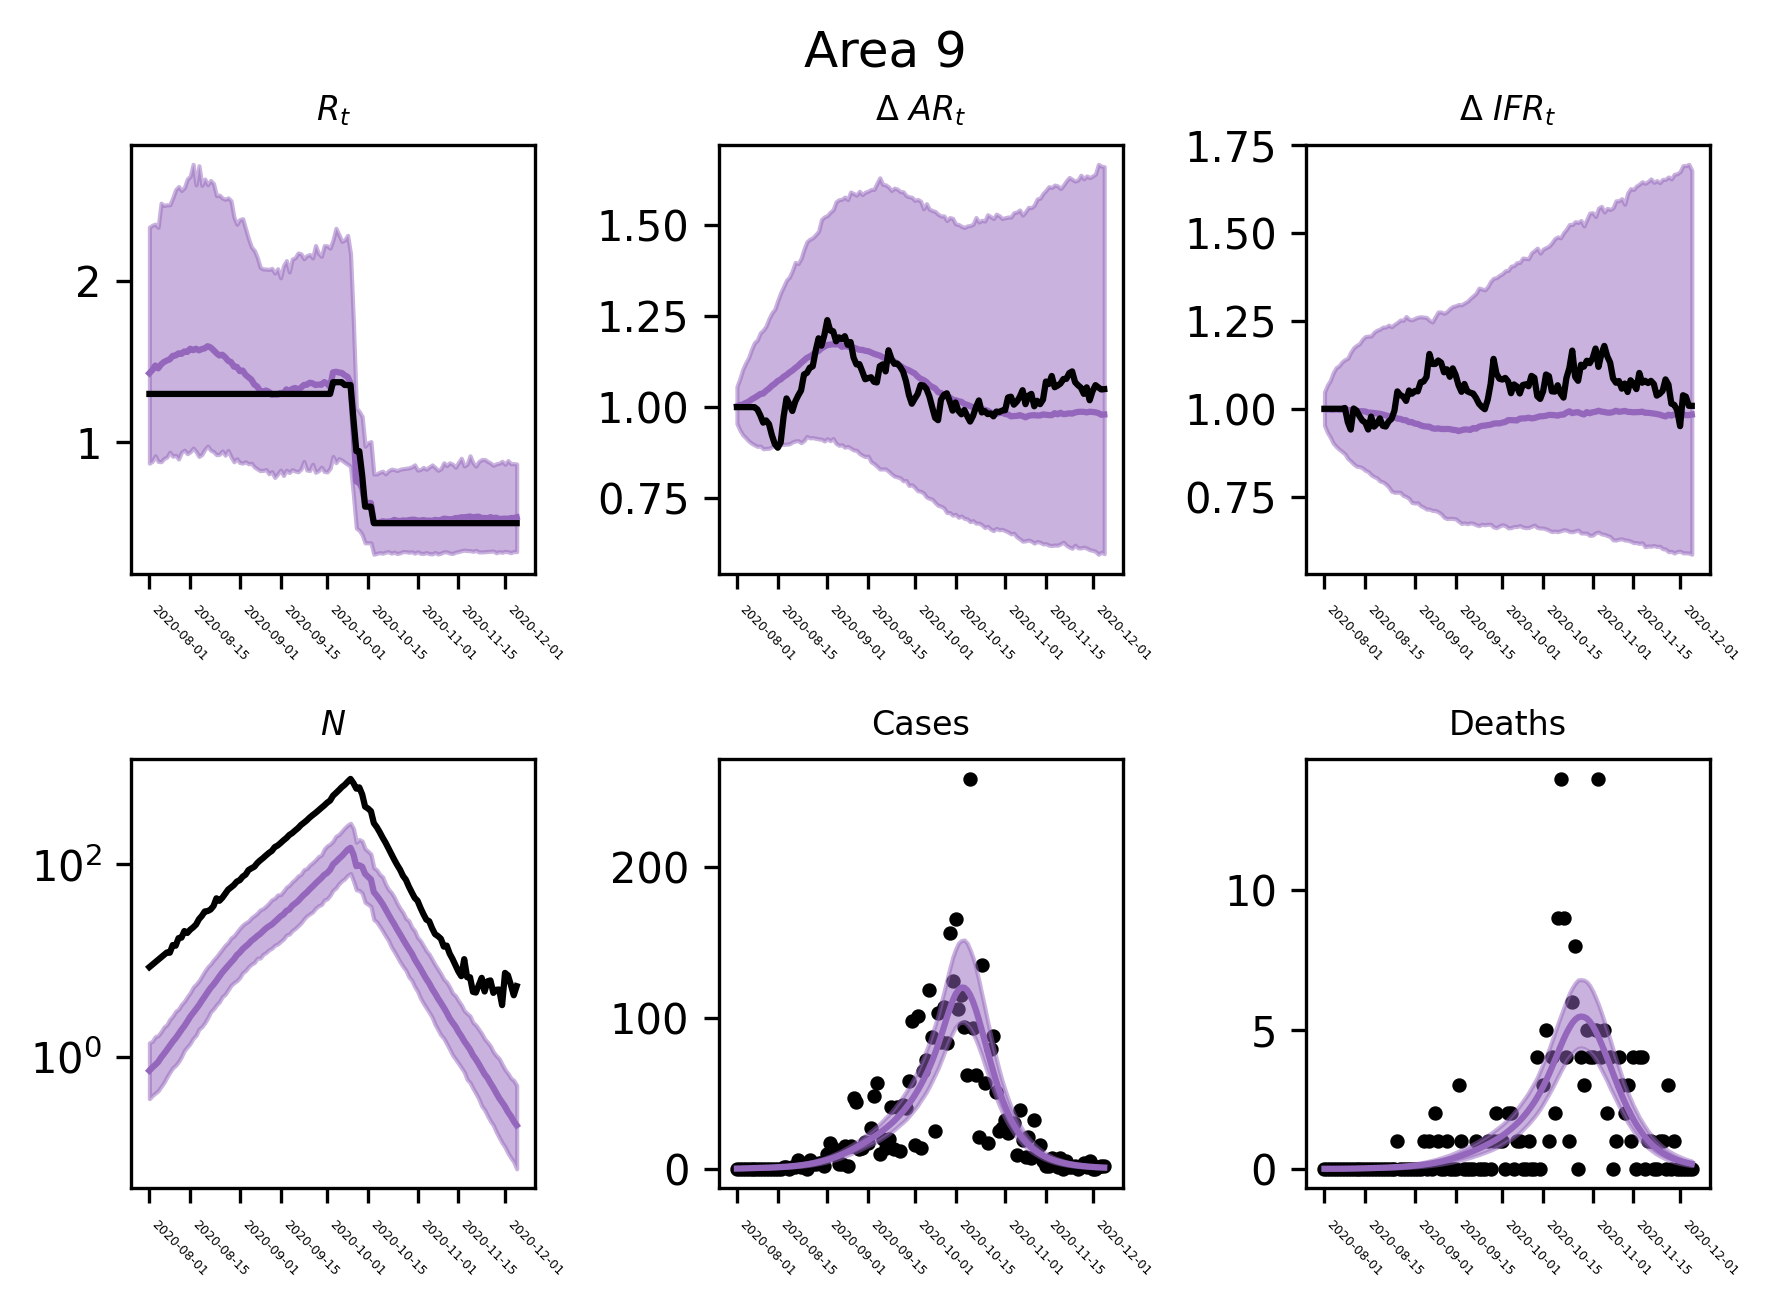

In [11]:
for r_i, r in enumerate(data.Rs):
    plt.figure(figsize=(6, 6), dpi=300)
    
    plt.subplot(331)
    plt.plot(data.Ds, np.median(posterior_samples['Rt'][:, r_i, :], axis=0), color='tab:purple')
    plt.plot(data.Ds, all_df.loc[r].loc[data.Ds]['R'], color='k')
    plt.fill_between(data.Ds, np.percentile(posterior_samples['Rt'][:, r_i, :], 2.5, axis=0), np.percentile(posterior_samples['Rt'][:, r_i, :], 97.5, axis=0), color='tab:purple', alpha=0.5)
    plt.xticks(fontsize=3, rotation=-45, ha='left')
    plt.title('$R_t$', fontsize=8)
    
    plt.subplot(332)
    plt.plot(data.Ds, np.percentile(np.exp(np.cumsum(posterior_samples['ar_rw'][:, r_i, 7:], axis=-1)), 50, axis=0), color='tab:purple')
    plt.plot(data.Ds, all_df.loc[r].loc[data.Ds]['AR']/all_df.loc[r].loc[data.Ds[0]]['AR'], color='k')
    plt.fill_between(data.Ds, np.percentile(np.exp(np.cumsum(posterior_samples['ar_rw'][:, r_i, 7:], axis=-1)), 2.5, axis=0), np.percentile(np.exp(np.cumsum(posterior_samples['ar_rw'][:, r_i, 7:], axis=-1)), 97.5, axis=0), color='tab:purple', alpha=0.5)
    plt.xticks(fontsize=3, rotation=-45, ha='left')
    plt.title('$\Delta\ AR_t$', fontsize=8)
    
    plt.subplot(333)
    plt.plot(data.Ds, np.percentile(np.exp(np.cumsum(posterior_samples['ifr_rw'][:, r_i, 7:], axis=-1)), 50, axis=0), color='tab:purple')
    plt.plot(data.Ds, all_df.loc[r].loc[data.Ds]['IFR']/all_df.loc[r].loc[data.Ds[0]]['IFR'], color='k')
    plt.fill_between(data.Ds, np.percentile(np.exp(np.cumsum(posterior_samples['ifr_rw'][:, r_i, 7:], axis=-1)), 2.5, axis=0), np.percentile(np.exp(np.cumsum(posterior_samples['ifr_rw'][:, r_i, 7:], axis=-1)), 97.5, axis=0), color='tab:purple', alpha=0.5)
    plt.xticks(fontsize=3, rotation=-45, ha='left')
    plt.title('$\Delta\ IFR_t$', fontsize=8)
    
    plt.subplot(334)
    plt.plot(data.Ds, np.percentile(posterior_samples['total_infections'][:, r_i, 7:], 50, axis=0), color='tab:purple')
    plt.plot(data.Ds, all_df.loc[r].loc[data.Ds]['N'], color='k')
    plt.fill_between(data.Ds, np.percentile(posterior_samples['total_infections'][:, r_i, 7:], 2.5, axis=0), np.percentile(posterior_samples['total_infections'][:, r_i, 7:], 97.5, axis=0), color='tab:purple', alpha=0.5)
    plt.xticks(fontsize=3, rotation=-45, ha='left')
    plt.yscale('log')
    plt.title('$N$', fontsize=8)
    
    plt.subplot(335)
    plt.plot(data.Ds, np.percentile(posterior_samples['expected_cases'][:, r_i, :], 50, axis=0), color='tab:purple')
    plt.scatter(data.Ds, all_df.loc[r].loc[data.Ds]['new_cases'], color='k', s=6)
    plt.fill_between(data.Ds, np.percentile(posterior_samples['expected_cases'][:, r_i, :], 2.5, axis=0), np.percentile(posterior_samples['expected_cases'][:, r_i, :], 97.5, axis=0), color='tab:purple', alpha=0.5)
    plt.xticks(fontsize=3, rotation=-45, ha='left')
    plt.title('Cases', fontsize=8)
    
    plt.subplot(336)
    plt.plot(data.Ds, np.percentile(posterior_samples['expected_deaths'][:, r_i, :], 50, axis=0), color='tab:purple')
    plt.scatter(data.Ds, all_df.loc[r].loc[data.Ds]['new_deaths'], color='k', s=6)
    plt.fill_between(data.Ds, np.percentile(posterior_samples['expected_deaths'][:, r_i, :], 2.5, axis=0), np.percentile(posterior_samples['expected_deaths'][:, r_i, :], 97.5, axis=0), color='tab:purple', alpha=0.5)
    plt.xticks(fontsize=3, rotation=-45, ha='left')
    plt.title('Deaths', fontsize=8)
    
    plt.tight_layout()
    plt.suptitle(f'{r}', y=1.01)

In [ ]:
import arviz as az

In [ ]:
azdata = az.from_numpyro(mcmc)

In [ ]:
az.plot_trace(data, var_names=['alpha_i'])

Not great ... the true NPI effects actually are linearly increasing with NPI index. 